In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import statsmodels.api as sm

C:\Users\pablo\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**Note**: on this notebook I am just practicing concepts of logistic regression. I am not considering some aspects related to machine learning like the imputation of missing values or the normalisation of the predictor variables. 

## Loading and processing the data

The dataset used in this notebook is an example dataset about accessing graduate school which was obtained from https://stats.idre.ucla.edu/r/dae/logit-regression/. The `admit` column corresponds to the two-level categorical response variable. The variables containing the `gre` and `gpa` scores of the candidate are numerical, whereas the variable `rank`, that indicates the prestige of the school, is categorical. 

In [2]:
df = pd.read_csv('data/binary.csv')
df.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


Let's examine the distribution of the predictor variables:

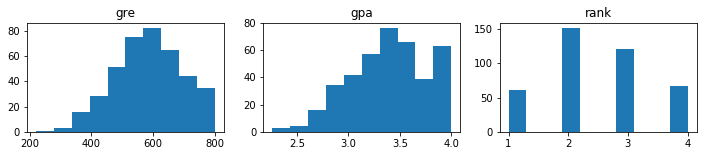

In [3]:
fig, ax = plt.subplots(1,3)

ax[0].hist(df['gre'])
ax[0].set_title('gre')

ax[1].hist(df['gpa'])
ax[1].set_title('gpa')

ax[2].hist(df['rank'])
ax[2].set_title('rank')

fig.set_figwidth(12)
fig.set_figheight(2)

Is there collinearity between any pair of variables?

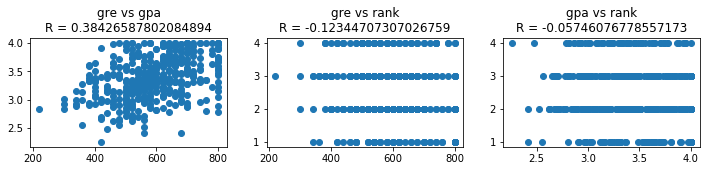

In [4]:
def compute_R(df, col1, col2):
    var1 = df[col1]
    var2 = df[col2]    
    return 1/(len(df)-1)*np.sum(((var1-var1.mean())/var1.std())*((var2-var2.mean())/var2.std()))

fig, ax = plt.subplots(1,3)

ax[0].plot(df['gre'], df['gpa'], 'o')
ax[0].set_title('gre vs gpa\nR = ' + str(compute_R(df, 'gre', 'gpa')))

ax[1].plot(df['gre'], df['rank'], 'o')
ax[1].set_title('gre vs rank\nR = ' + str(compute_R(df, 'gre', 'rank')))

ax[2].plot(df['gpa'], df['rank'], 'o')
ax[2].set_title('gpa vs rank\nR = ' + str(compute_R(df, 'gpa', 'rank')))

fig.set_figwidth(12)
fig.set_figheight(2)

Building indicator variables to replace the rank categorical variable:

In [5]:
values = np.unique(df['rank'])[0:-1]
for v in values:
    df['rank_' + str(v)] = (df['rank'] == v).astype(int)
del df['rank']
df.head()

,admit,gre,gpa,rank_1,rank_2,rank_3
0,0,380,3.61,0,0,1
1,1,660,3.67,0,0,1
2,1,800,4.00,1,0,0
3,1,640,3.19,0,0,0
4,0,520,2.93,0,0,0


## Logistic regression

Logistic regression is a type of generalised linear model in which the response variable is a two-level categorical variable that, for each observation, takes the value Yi = 1 with probability pi and the value Yi = 0 with probability Yi = 0.

A generalised linear model is a generalisation of linear regression in which the residuals can be non-normally distributed. This is achieved by linking the response variable to a multiple regression model by means of a transformation variable, usually the logit function:

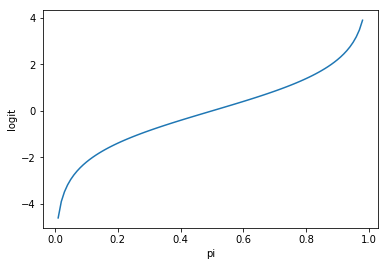

In [6]:
fig, ax = plt.subplots()
p = np.arange(0.01, 0.99, 0.01)
logit = np.log(p/(1-p))
ax.plot(p, logit)
ax.set_xlabel('pi')
ax.set_ylabel('logit')

The logistic regression model has the following form:
```
logit(pi) = b0 + b1*x1i + b2*x2i + ... + bk*xki
```
In order to fit a logistic regression model a function based on Newton method for numerical optimisation is commonly used:

In [7]:
Y = df['admit']
# Intercept is not included by default
X = df[['gre', 'gpa', 'rank_1', 'rank_2', 'rank_3']]
X = np.append(np.ones((X.shape[0], 1)), X, axis=1)
   

logit_model = sm.Logit(Y, X)
result = logit_model.fit()
# The following line is a workaround to make summary work
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.573147
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date:                Thu, 17 May 2018   Pseudo R-squ.:                 0.08292
Time:                        07:36:28   Log-Likelihood:                -229.26
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 7.578e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5414      1.138     -4.869      0.000      -7.772      -3.311
x1             0.0023      0.

When we plot the predicted probabilities of the observations versus the value returned by the logistic regression model for these observations, we can see the shape of the logit function:

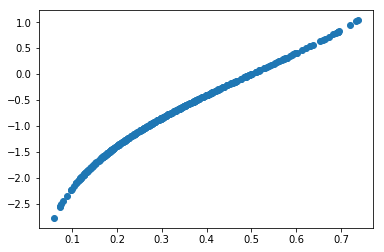

In [8]:
# predict returns the probabilities
fig, ax = plt.subplots()
ax.plot(result.predict(X), result.fittedvalues, 'o')

The following plot shows the residuals as the difference between the value of the response variable and the probability returned by the logistic regression model. This plot demonstrates the independence of the observations, since we cannot see any pattern in the data. The residuals are split into two groups due to the fact that the reponse variable is a two level categorical variable.

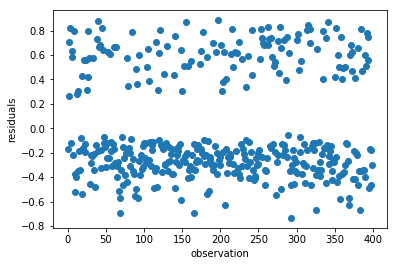

In [9]:
fig, ax = plt.subplots()
ax.plot(df['admit'] - result.predict(X), 'o')
ax.set_xlabel('observation')
ax.set_ylabel('residuals')

Another condition to apply logistic regression, aside from the observations being independent of each other, is that there exists a linear relationship between logit(pi) and each predictor variable, when the rest of the predictor variables are held constant. We can test this condition by plotting residuals versus the values of each predictor variable:

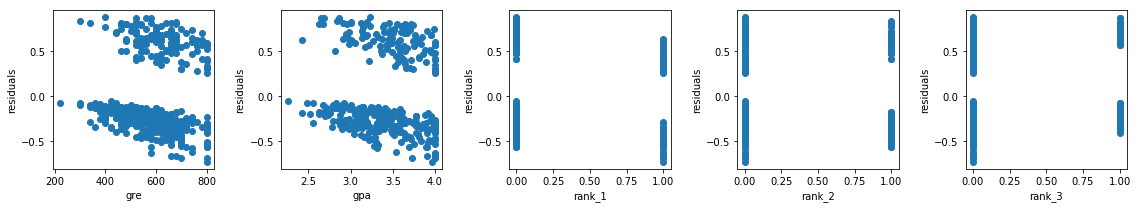

In [10]:
residuals = df['admit'] - result.predict(X)
predictors = ['gre', 'gpa', 'rank_1', 'rank_2', 'rank_3']

fig, ax = plt.subplots(1,len(predictors))

for i in range(len(predictors)):
    ax[i].plot(df[predictors[i]], residuals, 'o')
    ax[i].set_xlabel(predictors[i])
    ax[i].set_ylabel('residuals')
    
fig.set_figwidth(16)
fig.set_figheight(3)
fig.tight_layout()

Linearity seems to be fine in most cases, except maybe in the case of variables rank-2 and rank_3, that have different variabilities between groups. 

## Model selection

We are applying now stepwise model selection (forward selection and backward elimination) based on the p-value as the metric to select with variables add to/remove from the model. 

In forward selection, we start with an empty model and we add at each iteration the predictor variable with the lowest p-value, until it is not possible to add a variable which p-value is lower than the significance level (0.05 in our example)

In [11]:
Y = df['admit']
pending = ['gre', 'gpa', 'rank_1', 'rank_2', 'rank_3']
model = []
end = False
it = 1
while not end:
    end = True
    minimum = 1000
    for p in pending:
        model.append(p)
        X = df[model]
        X = np.append(np.ones((X.shape[0], 1)), X, axis=1)
        logit_model = sm.Logit(Y, X)
        result = logit_model.fit()

        if result.pvalues[-1] < minimum and result.pvalues[-1] < 0.05:
            to_add = p
            minimum = result.pvalues[-1]
            end = False
        
        model.remove(p)
        
    print('Iteration ' + str(it))
    it = it + 1
    if not end:
        print('adding ' + to_add)
        model.append(to_add)
        pending.remove(to_add)
    else:
        print('not adding any variable')
    print('---------------------------')
    
print('Final model:' +  str(model))
X = df[model]
X = np.append(np.ones((X.shape[0], 1)), X, axis=1)

logit_model = sm.Logit(Y, X)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.607570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.605532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.622736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617290
         Iterations 5
Iteration 1
adding rank_1
---------------------------
Optimization terminated successfully.
         Current function value: 0.590704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.591188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.594606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.603017
         Iterations 5
Iteration 2
adding gre
-----

In backward elimination we start with start with the full model. At each iteration we remove the variable which has the highest p-value, as long as this p-value is higher than the significance level (0.05 in this example)

In [12]:
Y = df['admit']
model = ['gre', 'gpa', 'rank_1', 'rank_2', 'rank_3']
end = False
it = 1
while not end:
    end = True
    
    X = df[model]
    X = np.append(np.ones((X.shape[0], 1)), X, axis=1)
    logit_model = sm.Logit(Y, X)
    result = logit_model.fit()
    
    index = np.argmax(result.pvalues.values)
    if result.pvalues.values[index] > 0.05:
        to_remove = model[index-1]
        end = False
         
    print('Iteration ' + str(it))
    it = it + 1
    if not end:
        print('removing ' + to_remove)
        model.remove(to_remove)
    else:
        print('not removing any variable')
    print('---------------------------')
    
print('Final model:' +  str(model))
X = df[model]
X = np.append(np.ones((X.shape[0], 1)), X, axis=1)

logit_model = sm.Logit(Y, X)
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.573147
         Iterations 6
Iteration 1
removing rank_3
---------------------------
Optimization terminated successfully.
         Current function value: 0.573514
         Iterations 6
Iteration 2
not removing any variable
---------------------------
Final model:['gre', 'gpa', 'rank_1', 'rank_2']
Optimization terminated successfully.
         Current function value: 0.573514
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      395
Method:                           MLE   Df Model:                            4
Date:                Thu, 17 May 2018   Pseudo R-squ.:                 0.08233
Time:                        07:36:30   Log-Likelihood:                -229.41
converged:                       True   LL-Null:   

In this case both methods resulted in the same final model. The only initial predictor variable that is not included in the final model is rank_3.

Let's compute the probability values from the logit predictions of the model for the training data

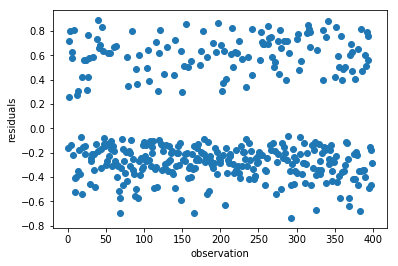

In [13]:
fig, ax = plt.subplots()
ax.plot(df['admit'] - result.predict(X), 'o')
ax.set_xlabel('observation')
ax.set_ylabel('residuals')